# **An analysis of different optimizers used in a deep learning problem:**

## **Project Description:**


> This project consists of a study of various optimization algroithms which are used in deep learning problems. Here I have choosen a multiclass image classification problem using Convolutional Neural Networks. I have used different optimizers while training my model and have achieved various kinds of results.



## **About the dataset:**


The dataset used here is taken from kaggle which has four classes-


> 
1.   Sunrise (357 images)
2.   Rain (215 images)
3.   Cloudy (300 images)
4.   Shine (253 images)

The dataset provides a platform for outdoor weather analysis by extracting various features for recognizing different weather conditions. Many industries have the need to identify current and past weather conditions. The data helps them plan, organize, and/or optimize their operations. For example, farmers might look at the current weather to decide if the sprinklers should be turned on or off. Ski resort operators might choose to enable snowmaking machines based on varying weather conditions across the mountain. Construction workers might plan out the supplies and rain gear they’ll need for a remote job site.
Currently, making such decisions can require manually looking at video feeds from remote cameras, relying on weather forecasts, or simply looking out the window.


Using machine learning (ML) offers the potential to automate this by providing a digital eye. More specifically, if an image recognition ML model could be built to identify conditions by simply looking at images of the weather, it could be deployed in scenarios like those described above. For example, a camera feed on a farm could be processed by an ML model deployed on an IoT device at the edge (e.g., on a smart camera). That model can then be used to automatically determine the current weather conditions and enable or disable sprinkler valves accordingly.

[Source](https://towardsdatascience.com/use-case-automated-weather-analysis-using-image-recognition-c6b4659557ac)








### **Link to Notebooks:**
1. Data Preprocessing: [Click here](https://)
2. Training & Analysis of various optimizers : [Click here](https://)




## **Importing Necessary Packages:**

In [1]:
import os
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import random_split
import numpy as np

## **Mounting Google Drive:**



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Check For CUDA:**

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
data_dir = '/content/gdrive/MyDrive/Weather_data'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/TRAIN")
print(classes)

['TRAIN', 'TEST']
['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [5]:
shine_files = os.listdir(data_dir + "/TRAIN/Shine")
print('No. of training examples for shine:', len(shine_files))
print(shine_files[:5])

No. of training examples for shine: 202
['shine145.jpg', 'shine146.jpg', 'shine147.jpg', 'shine148.jpg', 'shine149.jpg']


In [6]:
cloudy_files = os.listdir(data_dir + "/TEST/Cloudy")
print('No. of test examples for cloudy:', len(cloudy_files))
print(cloudy_files[:5])

No. of test examples for cloudy: 50
['cloudy1.jpg', 'cloudy10.jpg', 'cloudy100.jpg', 'cloudy101.jpg', 'cloudy102.jpg']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler


In [8]:
train_data = ImageFolder(data_dir+'/TRAIN', transform=ToTensor())
test_data=ImageFolder(data_dir+'/TEST', transform=ToTensor())

In [9]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

## **Train and Validation Split:**

In [10]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [11]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [12]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [13]:
img,label=train_data[0]
img.shape

torch.Size([3, 32, 32])

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

## **Data Visualization:**

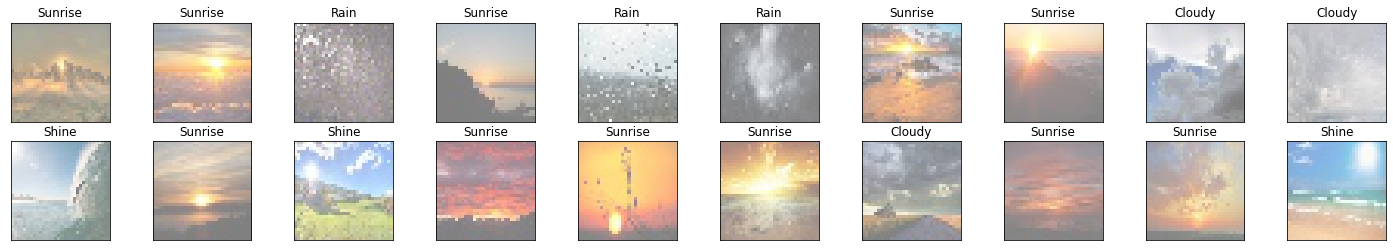

In [15]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## **CNN architecture:**

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 4)
        self.fc2 = nn.Linear(500, 4)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [17]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

In [18]:
import torch.optim as optim

### I have implemented SGD, SGD with momentum, RMSProp & Adam with three different learning rates- a large learning rate, an intermediate learning rate, and a very small learning rate.

## **Vanilla SGD** :

The word ‘stochastic‘ means a system or a process that is linked with a random probability. Hence, in Stochastic Gradient Descent, a few samples are selected randomly instead of the whole data set for each iteration. In Gradient Descent, there is a term called “batch” which denotes the total number of samples from a dataset that is used for calculating the gradient for each iteration. In typical Gradient Descent optimization, like Batch Gradient Descent, the batch is taken to be the whole dataset.



> $x_{k+1}=x_k-t_k \nabla f(x_k)^{(i:i+m)}$



In SGD, since only a batch from the dataset is chosen at random for each iteration, the path taken by the algorithm to reach the minima is usually noisier than your typical Gradient Descent algorithm. But that doesn’t matter all that much because the path taken by the algorithm does not matter, as long as we reach the minima and with a significantly shorter training time.

### **Learning Rate =0.01:**

In [20]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
vanilla_sgd1 = optim.SGD(model.parameters(), lr=0.01)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [21]:
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss

train_loss_SGD1 = []
valid_loss_SGD1 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        vanilla_sgd1.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        vanilla_sgd1.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.weight.grad))
    train_loss_SGD1.append(train_loss)
    valid_loss_SGD1.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model2.state_dict(), 'model_weather2.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.381961 	Validation Loss: 1.372433
conv1 grads tensor(0.0213, device='cuda:0')
conv2 grads tensor(0.0641, device='cuda:0')
Validation loss decreased (inf --> 1.372433).  Saving model ...
Epoch: 2 	Training Loss: 1.375600 	Validation Loss: 1.363008
conv1 grads tensor(0.0181, device='cuda:0')
conv2 grads tensor(0.0680, device='cuda:0')
Validation loss decreased (1.372433 --> 1.363008).  Saving model ...
Epoch: 3 	Training Loss: 1.368975 	Validation Loss: 1.354664
conv1 grads tensor(0.0299, device='cuda:0')
conv2 grads tensor(0.0955, device='cuda:0')
Validation loss decreased (1.363008 --> 1.354664).  Saving model ...
Epoch: 4 	Training Loss: 1.364762 	Validation Loss: 1.346445
conv1 grads tensor(0.0584, device='cuda:0')
conv2 grads tensor(0.1266, device='cuda:0')
Validation loss decreased (1.354664 --> 1.346445).  Saving model ...
Epoch: 5 	Training Loss: 1.357728 	Validation Loss: 1.337416
conv1 grads tensor(0.0429, device='cuda:0')
conv2 grads tensor(0.0795, d

#### **Distribution of the gradient norms:**

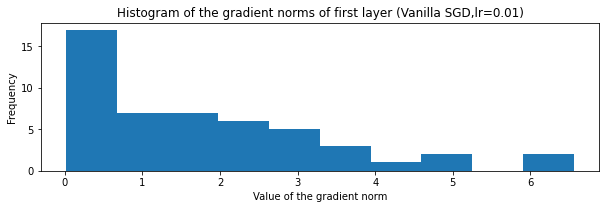

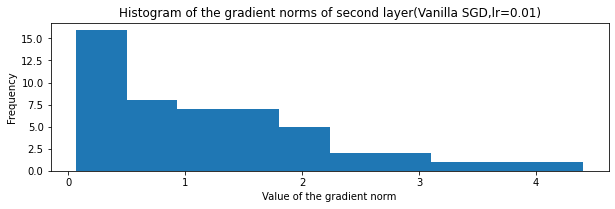

In [23]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())


plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (Vanilla SGD,lr=0.01)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(Vanilla SGD,lr=0.01)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

#### **Training and Validation Loss Curves:**

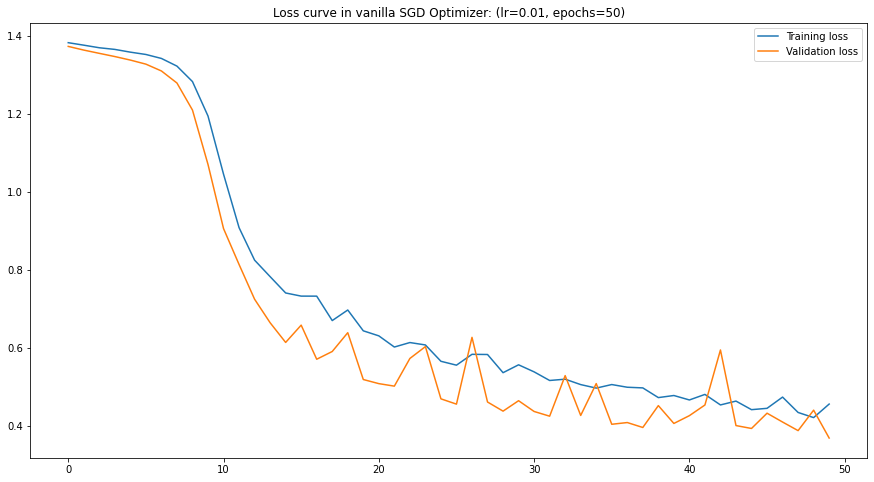

In [24]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_SGD1,label="Training loss")
plt.plot(valid_loss_SGD1,label="Validation loss")
plt.title("Loss curve in vanilla SGD Optimizer: (lr=0.01, epochs=50)")
plt.legend()
plt.show()

### **Learning Rate=0.001:**

In [27]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
vanilla_sgd2 = optim.SGD(model.parameters(), lr=0.001)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [28]:
n_epochs = 1000

valid_loss_min = np.Inf # track change in validation loss

train_loss_SGD2 = []
valid_loss_SGD2 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        vanilla_sgd2.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        vanilla_sgd2.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.weight.grad))
    train_loss_SGD2.append(train_loss)
    valid_loss_SGD2.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model2.state_dict(), 'model_weather2.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.386667 	Validation Loss: 1.385657
conv1 grads tensor(0.0325, device='cuda:0')
conv2 grads tensor(0.0840, device='cuda:0')
Validation loss decreased (inf --> 1.385657).  Saving model ...
Epoch: 2 	Training Loss: 1.385853 	Validation Loss: 1.384296
conv1 grads tensor(0.0261, device='cuda:0')
conv2 grads tensor(0.0716, device='cuda:0')
Validation loss decreased (1.385657 --> 1.384296).  Saving model ...
Epoch: 3 	Training Loss: 1.384475 	Validation Loss: 1.382991
conv1 grads tensor(0.0234, device='cuda:0')
conv2 grads tensor(0.0719, device='cuda:0')
Validation loss decreased (1.384296 --> 1.382991).  Saving model ...
Epoch: 4 	Training Loss: 1.384109 	Validation Loss: 1.381721
conv1 grads tensor(0.0299, device='cuda:0')
conv2 grads tensor(0.0895, device='cuda:0')
Validation loss decreased (1.382991 --> 1.381721).  Saving model ...
Epoch: 5 	Training Loss: 1.382308 	Validation Loss: 1.380514
conv1 grads tensor(0.0291, device='cuda:0')
conv2 grads tensor(0.0748, d

#### **Distribution of the gradient norms:**

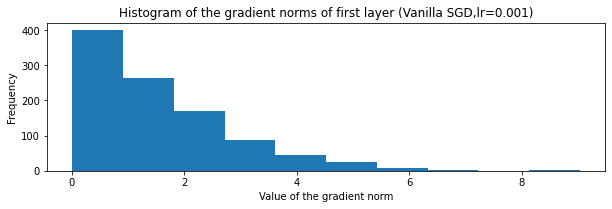

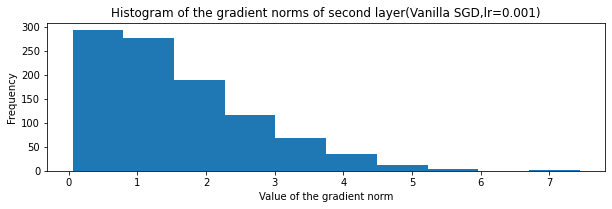

In [29]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())


plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (Vanilla SGD,lr=0.001)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(Vanilla SGD,lr=0.001)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

#### **Training and Validation Loss Curves:** 

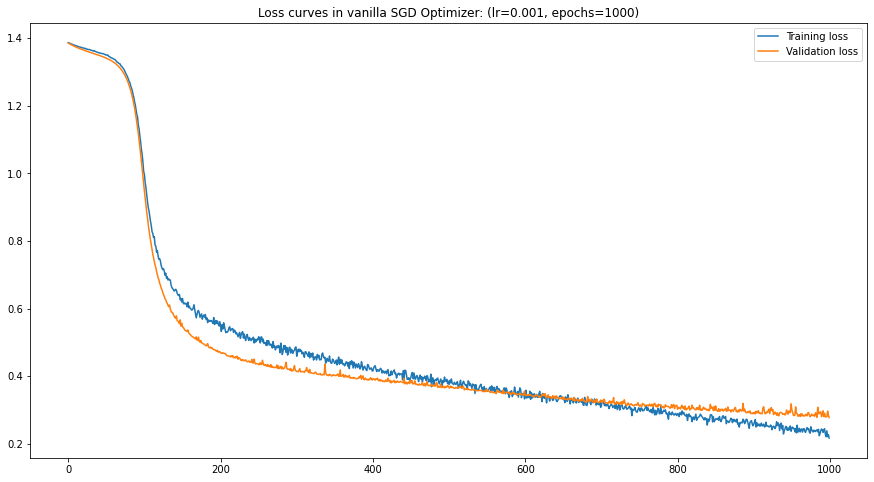

In [30]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_SGD2,label="Training loss")
plt.plot(valid_loss_SGD2,label="Validation loss")
plt.title("Loss curves in vanilla SGD Optimizer: (lr=0.001, epochs=1000)")
plt.legend()
plt.show()

### **Learning Rate=0.1**

In [36]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
vanilla_sgd3 = optim.SGD(model.parameters(), lr=0.1)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [37]:
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

train_loss_SGD3 = []
valid_loss_SGD3 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        vanilla_sgd3.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        vanilla_sgd3.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.weight.grad))
    train_loss_SGD3.append(train_loss)
    valid_loss_SGD3.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model2.state_dict(), 'model_weather2.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.362671 	Validation Loss: 1.279544
conv1 grads tensor(0.2414, device='cuda:0')
conv2 grads tensor(0.2757, device='cuda:0')
Validation loss decreased (inf --> 1.279544).  Saving model ...
Epoch: 2 	Training Loss: 1.167703 	Validation Loss: 0.816219
conv1 grads tensor(0.2715, device='cuda:0')
conv2 grads tensor(0.2371, device='cuda:0')
Validation loss decreased (1.279544 --> 0.816219).  Saving model ...
Epoch: 3 	Training Loss: 0.903445 	Validation Loss: 1.422433
conv1 grads tensor(0.1509, device='cuda:0')
conv2 grads tensor(0.1182, device='cuda:0')
Epoch: 4 	Training Loss: 1.215474 	Validation Loss: 1.397842
conv1 grads tensor(8.0036, device='cuda:0')
conv2 grads tensor(4.4600, device='cuda:0')
Epoch: 5 	Training Loss: 1.380428 	Validation Loss: 1.240588
conv1 grads tensor(0.2170, device='cuda:0')
conv2 grads tensor(0.2040, device='cuda:0')
Epoch: 6 	Training Loss: 1.083590 	Validation Loss: 0.825121
conv1 grads tensor(0.5476, device='cuda:0')
conv2 grads tenso

#### **Distribution of Gradient Norms:**

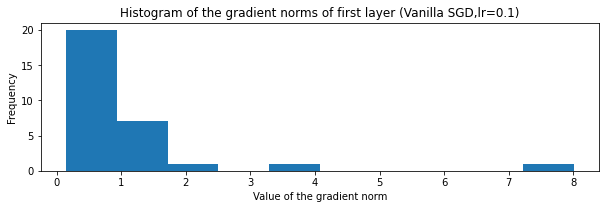

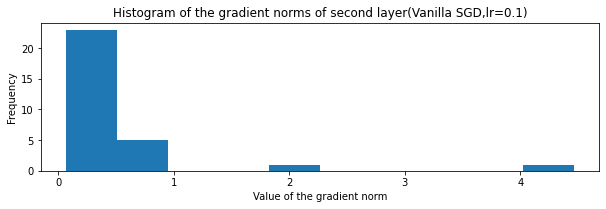

In [38]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())


plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (Vanilla SGD,lr=0.1)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(Vanilla SGD,lr=0.1)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

#### **Training & Validation Loss Curves:**

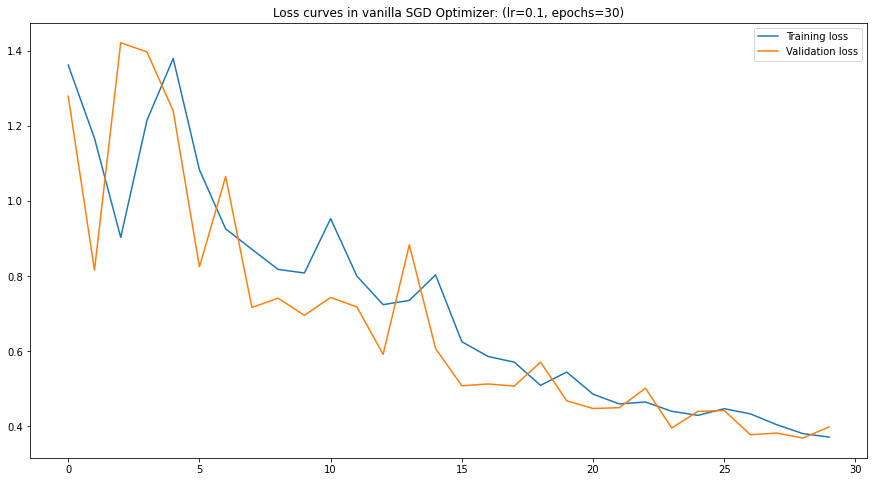

In [39]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_SGD3,label="Training loss")
plt.plot(valid_loss_SGD3,label="Validation loss")
plt.title("Loss curves in vanilla SGD Optimizer: (lr=0.1, epochs=30)")
plt.legend()
plt.show()

## **Stochastic Gradient Descent with momentum:**
> SGD with momentum is a method which helps accelerate gradients vectors in the right directions, thus leading to faster converging.


> $v_k=mv_{k-1}+t_k \nabla f(x_k)$


> $x_{k+1}=x_k-v_k$ ,where $m ∈ (0, 1]$ determines for how many iterations the previous gradients are incorporated into the
current update






#### Why momentum works:
> With Stochastic Gradient Descent we don’t compute the exact derivate of our loss function. Instead, we’re estimating it on a small batch. Which means we’re not always going in the optimal direction, because our derivatives are ‘noisy’.  So, exponentially weighed averages can provide us a better estimate which is closer to the actual derivate than our noisy calculations. This is one reason why momentum might work better than classic SGD.


> Ravines are common near local minimas in deep learning and SGD has troubles navigating them.SGD will tend to oscillate across the narrow ravine since the negative gradient will point down one of the steep sides rather than along the ravine towards the optimum. Momentum helps accelerate gradients in the right direction








### **Learning rate=0.01 (Intermediate lr)**

In [44]:
# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01,momentum=0.7)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [45]:
# number of epochs to train the model
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss

train_loss_list_4 = []
valid_loss_list_4 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_sgd.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_sgd.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.weight.grad))
    train_loss_list_4.append(train_loss)
    valid_loss_list_4.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model2.state_dict(), 'model_weather2.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.372562 	Validation Loss: 1.344155
conv1 grads tensor(0.0308, device='cuda:0')
conv2 grads tensor(0.0836, device='cuda:0')
Validation loss decreased (inf --> 1.344155).  Saving model ...
Epoch: 2 	Training Loss: 1.347450 	Validation Loss: 1.303406
conv1 grads tensor(0.1357, device='cuda:0')
conv2 grads tensor(0.2739, device='cuda:0')
Validation loss decreased (1.344155 --> 1.303406).  Saving model ...
Epoch: 3 	Training Loss: 1.228805 	Validation Loss: 0.952576
conv1 grads tensor(0.4274, device='cuda:0')
conv2 grads tensor(0.5715, device='cuda:0')
Validation loss decreased (1.303406 --> 0.952576).  Saving model ...
Epoch: 4 	Training Loss: 0.847540 	Validation Loss: 0.721545
conv1 grads tensor(0.8153, device='cuda:0')
conv2 grads tensor(0.8088, device='cuda:0')
Validation loss decreased (0.952576 --> 0.721545).  Saving model ...
Epoch: 5 	Training Loss: 0.755060 	Validation Loss: 0.568057
conv1 grads tensor(5.7374, device='cuda:0')
conv2 grads tensor(4.0547, d

#### **Distribution of Gradient Norms:**

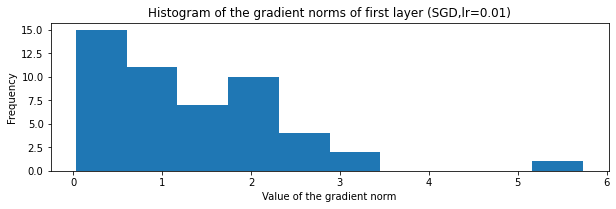

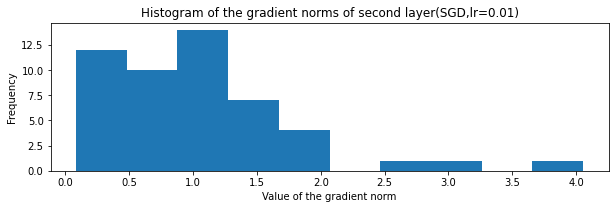

In [46]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())


plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (SGD,lr=0.01)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(SGD,lr=0.01)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

#### **Training and Validation Loss Curves:**

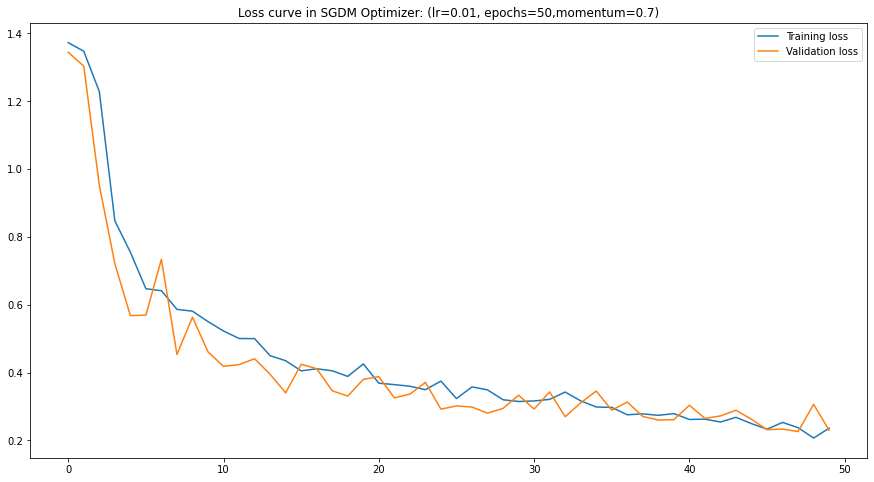

In [47]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_list_4,label="Training loss")
plt.plot(valid_loss_list_4,label="Validation loss")
plt.title("Loss curve in SGDM Optimizer: (lr=0.01, epochs=50,momentum=0.7)")
plt.legend()
plt.show()

### **Learning rate=0.001 (Small lr)**

In [48]:
# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.0001,momentum=0.7)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [49]:
# number of epochs to train the model
n_epochs = 1000

valid_loss_min = np.Inf # track change in validation loss

train_loss_list_5 = []
valid_loss_list_5 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_sgd.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_sgd.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.weight.grad))
    train_loss_list_5.append(train_loss)
    valid_loss_list_5.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model2.state_dict(), 'model_weather2.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.390608 	Validation Loss: 1.392530
conv1 grads tensor(0.0429, device='cuda:0')
conv2 grads tensor(0.0794, device='cuda:0')
Validation loss decreased (inf --> 1.392530).  Saving model ...
Epoch: 2 	Training Loss: 1.391197 	Validation Loss: 1.392042
conv1 grads tensor(0.0339, device='cuda:0')
conv2 grads tensor(0.0708, device='cuda:0')
Validation loss decreased (1.392530 --> 1.392042).  Saving model ...
Epoch: 3 	Training Loss: 1.390619 	Validation Loss: 1.391591
conv1 grads tensor(0.0246, device='cuda:0')
conv2 grads tensor(0.0525, device='cuda:0')
Validation loss decreased (1.392042 --> 1.391591).  Saving model ...
Epoch: 4 	Training Loss: 1.389988 	Validation Loss: 1.391110
conv1 grads tensor(0.0191, device='cuda:0')
conv2 grads tensor(0.0500, device='cuda:0')
Validation loss decreased (1.391591 --> 1.391110).  Saving model ...
Epoch: 5 	Training Loss: 1.389390 	Validation Loss: 1.390642
conv1 grads tensor(0.0162, device='cuda:0')
conv2 grads tensor(0.0388, d

#### **Distribution of Gradient norms:**

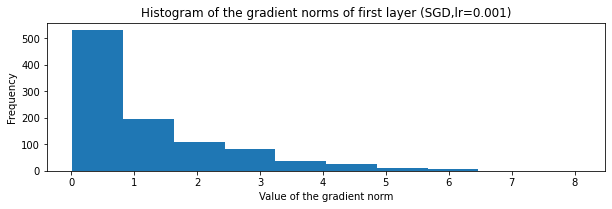

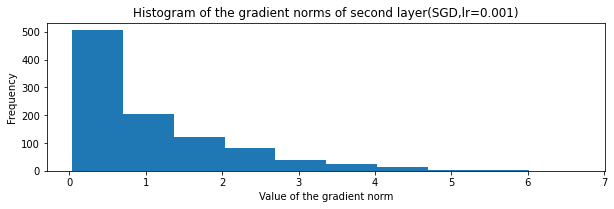

In [50]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())


plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (SGD,lr=0.001)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(SGD,lr=0.001)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

#### **Train and Validation Loss Curves:**

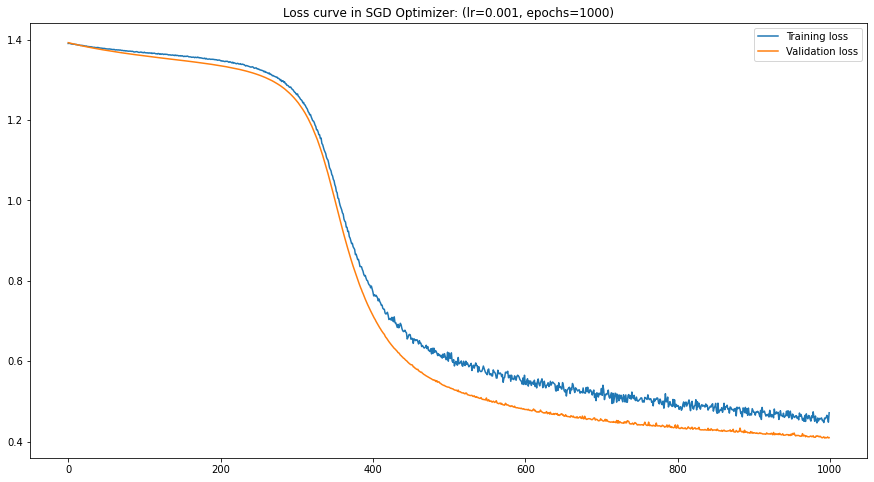

In [51]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_list_5,label="Training loss")
plt.plot(valid_loss_list_5,label="Validation loss")
plt.title("Loss curve in SGD Optimizer: (lr=0.001, epochs=1000)")
plt.legend()
plt.show()

### **Learning rate=0.1 (large learning rate)**

In [43]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.1,momentum=0.7)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [44]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

train_loss_list_6 = []
valid_loss_list_6 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_sgd.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_sgd.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.weight.grad))
    train_loss_list_6.append(train_loss)
    valid_loss_list_6.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model2.state_dict(), 'model_weather2.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.296366 	Validation Loss: 1.060172
conv1 grads tensor(0.7079, device='cuda:0')
conv2 grads tensor(0.1425, device='cuda:0')
Validation loss decreased (inf --> 1.060172).  Saving model ...
Epoch: 2 	Training Loss: 1.310615 	Validation Loss: 0.981356
conv1 grads tensor(0.5825, device='cuda:0')
conv2 grads tensor(0.1930, device='cuda:0')
Validation loss decreased (1.060172 --> 0.981356).  Saving model ...
Epoch: 3 	Training Loss: 0.987545 	Validation Loss: 0.865032
conv1 grads tensor(0.1607, device='cuda:0')
conv2 grads tensor(0.0758, device='cuda:0')
Validation loss decreased (0.981356 --> 0.865032).  Saving model ...
Epoch: 4 	Training Loss: 0.919196 	Validation Loss: 0.923201
conv1 grads tensor(0.4221, device='cuda:0')
conv2 grads tensor(0.2225, device='cuda:0')
Epoch: 5 	Training Loss: 0.755310 	Validation Loss: 0.725519
conv1 grads tensor(0.4065, device='cuda:0')
conv2 grads tensor(0.2146, device='cuda:0')
Validation loss decreased (0.865032 --> 0.725519).  S

#### **Distribution of gradient norms:**

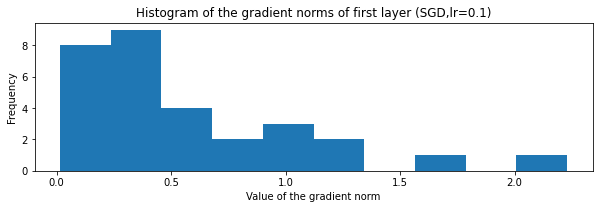

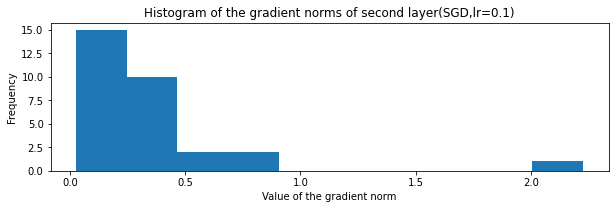

In [45]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())


plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (SGD,lr=0.1)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(SGD,lr=0.1)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

#### **Training and Validation Curves:**

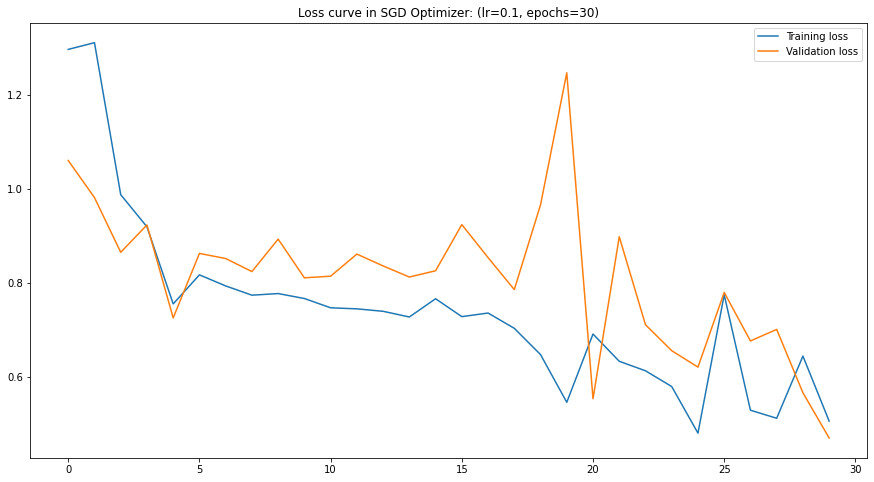

In [46]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_list_6,label="Training loss")
plt.plot(valid_loss_list_6,label="Validation loss")
plt.title("Loss curve in SGD Optimizer: (lr=0.1, epochs=30)")
plt.legend()
plt.show()

## **RMSProp:**
> Root Mean Squared Propagation, or RMSProp, is an extension of gradient descent and the AdaGrad version of gradient descent that uses a decaying average of partial gradients in the adaptation of the step size for each parameter. The use of a decaying moving average allows the algorithm to forget early gradients and focus on the most recently observed partial gradients seen during the progress of the search, overcoming the limitation of AdaGrad.



> $ E[\nabla f(x)^2]_k = \rho E[\nabla f(x)^2]_{k-1}+(1-\rho)\nabla f(x_k)^2$


> $x_{k+1}=x_k-\frac{t}{\sqrt{E[\nabla f(x)^2]_k+\varepsilon}} $, where $\rho$ is a decay constant (e.g., 0.9)







### **Learning rate=0.01:**

In [118]:
# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.01)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [119]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss

train_loss_list_7 = []
valid_loss_list_7 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_rmsprop.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_rmsprop.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.weight.grad))
    train_loss_list_7.append(train_loss)
    valid_loss_list_7.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model3.state_dict(), 'model_weather3.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 422.277956 	Validation Loss: 1.329853
conv1 grads tensor(0.0277, device='cuda:0')
conv2 grads tensor(0.1760, device='cuda:0')
Validation loss decreased (inf --> 1.329853).  Saving model ...
Epoch: 2 	Training Loss: 1.327923 	Validation Loss: 1.325266
conv1 grads tensor(0.0728, device='cuda:0')
conv2 grads tensor(0.9214, device='cuda:0')
Validation loss decreased (1.329853 --> 1.325266).  Saving model ...
Epoch: 3 	Training Loss: 1.313652 	Validation Loss: 1.288585
conv1 grads tensor(0.2154, device='cuda:0')
conv2 grads tensor(0.4917, device='cuda:0')
Validation loss decreased (1.325266 --> 1.288585).  Saving model ...
Epoch: 4 	Training Loss: 1.294616 	Validation Loss: 1.277677
conv1 grads tensor(0.1546, device='cuda:0')
conv2 grads tensor(0.5033, device='cuda:0')
Validation loss decreased (1.288585 --> 1.277677).  Saving model ...
Epoch: 5 	Training Loss: 1.271209 	Validation Loss: 1.255979
conv1 grads tensor(0.4006, device='cuda:0')
conv2 grads tensor(1.0423,

#### **Distribution of the gradient norms:**

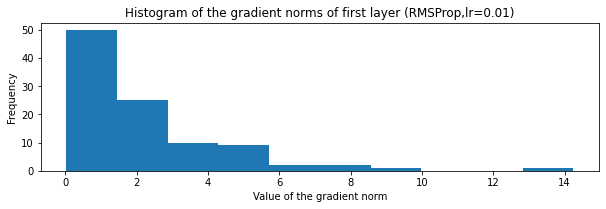

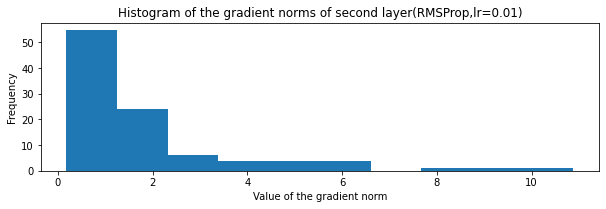

In [120]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())

plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (RMSProp,lr=0.01)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(RMSProp,lr=0.01)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

#### **Training and Validation Loss Curves:**

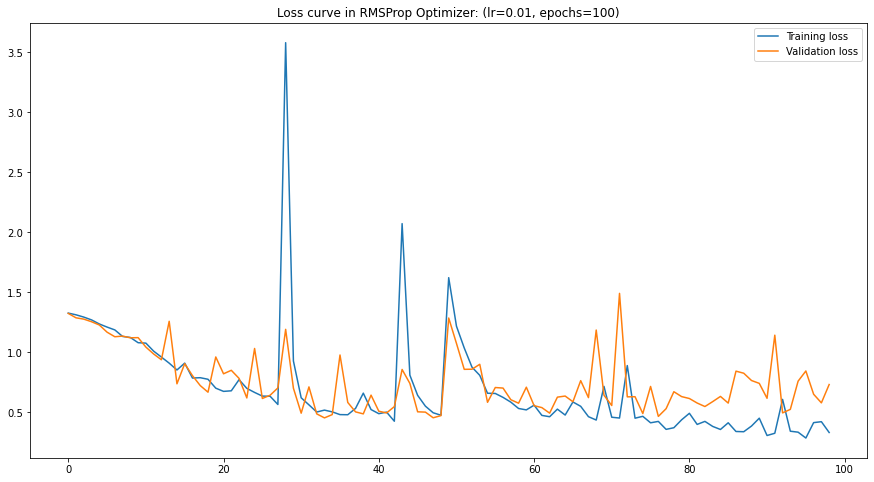

In [121]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_list_7[1:],label="Training loss")
plt.plot(valid_loss_list_7[1:],label="Validation loss")
plt.title("Loss curve in RMSProp Optimizer: (lr=0.01, epochs=100)")
plt.legend()
plt.show()

### **Learning rate=0.001:**


In [19]:
# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [20]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss

train_loss_list_8 = []
valid_loss_list_8 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_rmsprop.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_rmsprop.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.weight.grad))
    train_loss_list_8.append(train_loss)
    valid_loss_list_8.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model3.state_dict(), 'model_weather3.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 1.122827 	Validation Loss: 0.748293
conv1 grads tensor(0.8304, device='cuda:0')
conv2 grads tensor(0.4942, device='cuda:0')
Validation loss decreased (inf --> 0.748293).  Saving model ...
Epoch: 2 	Training Loss: 0.633276 	Validation Loss: 0.682534
conv1 grads tensor(3.1704, device='cuda:0')
conv2 grads tensor(1.7003, device='cuda:0')
Validation loss decreased (0.748293 --> 0.682534).  Saving model ...
Epoch: 3 	Training Loss: 0.493793 	Validation Loss: 0.594805
conv1 grads tensor(1.0473, device='cuda:0')
conv2 grads tensor(0.4501, device='cuda:0')
Validation loss decreased (0.682534 --> 0.594805).  Saving model ...
Epoch: 4 	Training Loss: 0.422187 	Validation Loss: 0.493899
conv1 grads tensor(2.5589, device='cuda:0')
conv2 grads tensor(0.9295, device='cuda:0')
Validation loss decreased (0.594805 --> 0.493899).  Saving model ...
Epoch: 5 	Training Loss: 0.390334 	Validation Loss: 0.445636
conv1 grads tensor(1.6994, device='cuda:0')
conv2 grads tensor(0.7741, d

#### **Distribution of the gradient norms:**

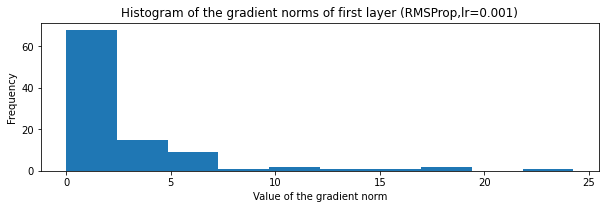

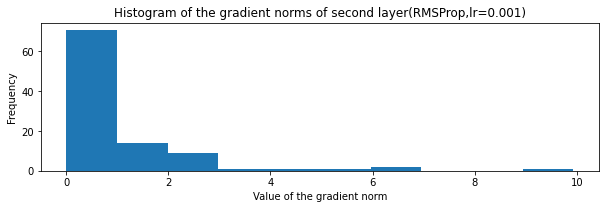

In [22]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())


plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (RMSProp,lr=0.001)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(RMSProp,lr=0.001)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

#### **Training and Validation Loss Curves:**

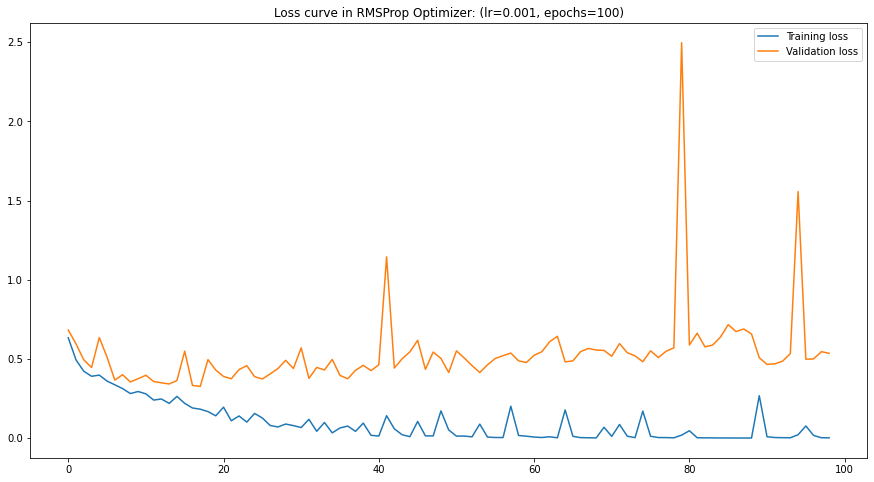

In [24]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_list_8[1:],label="Training loss")
plt.plot(valid_loss_list_8[1:],label="Validation loss")
plt.title("Loss curve in RMSProp Optimizer: (lr=0.001, epochs=100)")
plt.legend()
plt.show()

### **Learning rate=0.0001**

In [25]:
# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.0001)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [26]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss

train_loss_list_9 = []
valid_loss_list_9 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_rmsprop.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_rmsprop.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.weight.grad))
    train_loss_list_9.append(train_loss)
    valid_loss_list_9.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model3.state_dict(), 'model_weather3.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.167697 	Validation Loss: 0.899445
conv1 grads tensor(1.9241, device='cuda:0')
conv2 grads tensor(2.9357, device='cuda:0')
Validation loss decreased (inf --> 0.899445).  Saving model ...
Epoch: 2 	Training Loss: 0.759634 	Validation Loss: 0.686800
conv1 grads tensor(2.6428, device='cuda:0')
conv2 grads tensor(3.7674, device='cuda:0')
Validation loss decreased (0.899445 --> 0.686800).  Saving model ...
Epoch: 3 	Training Loss: 0.634955 	Validation Loss: 0.636679
conv1 grads tensor(5.7761, device='cuda:0')
conv2 grads tensor(7.9450, device='cuda:0')
Validation loss decreased (0.686800 --> 0.636679).  Saving model ...
Epoch: 4 	Training Loss: 0.594183 	Validation Loss: 0.612633
conv1 grads tensor(1.3880, device='cuda:0')
conv2 grads tensor(1.6100, device='cuda:0')
Validation loss decreased (0.636679 --> 0.612633).  Saving model ...
Epoch: 5 	Training Loss: 0.537118 	Validation Loss: 0.623979
conv1 grads tensor(8.4290, device='cuda:0')
conv2 grads tensor(11.0990, 

#### **Distribution of the Gradient Norms:**

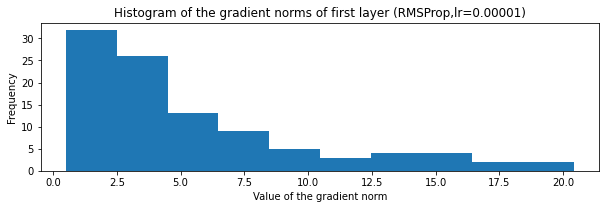

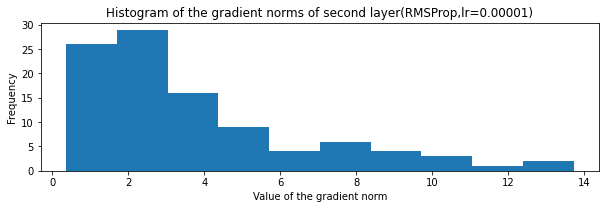

In [67]:

l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())

plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (RMSProp,lr=0.0001)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(RMSProp,lr=0.0001)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()


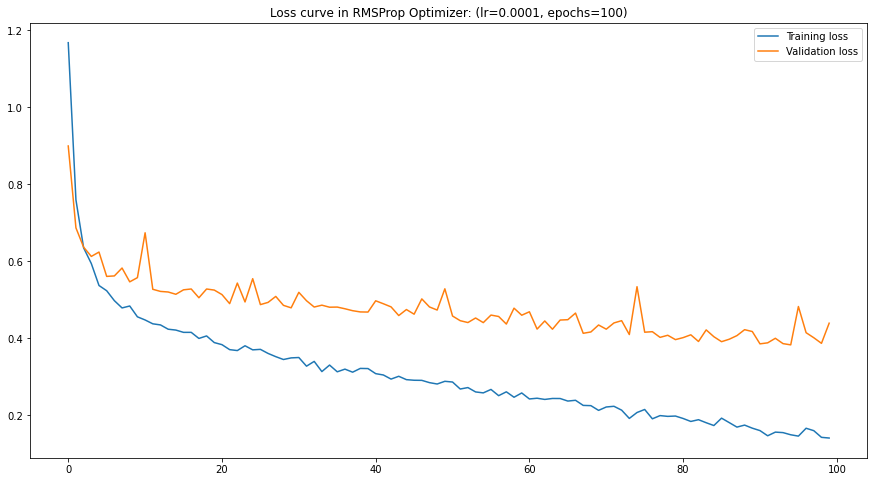

In [27]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_list_9,label="Training loss")
plt.plot(valid_loss_list_9,label="Validation loss")
plt.title("Loss curve in RMSProp Optimizer: (lr=0.0001, epochs=100)")
plt.legend()
plt.show()

# Adam Optimizer:

---
> Adam optimization algorithm is an extension to stochastic gradient descent.


> It was presented in 2015.The name **Adam** is derived from **Adaptive moment estimation**


> The authors describe Adam as combining the advantages of two other extensions of stochastic gradient descent-

*   Adaptive Gradient Algorithm(AdaGrad)
*   Root Mean Square Propagation (RMSProp)


> $m_k=\beta_1 m_{k-1}+(1-\beta_1) \nabla f(x_k)$


> $v_k=\beta_2 v_{k-1}+(1-\beta_2)\nabla f(x_k)^2$


> $m_k^*=\frac{m_k}{1-\beta_1 ^k} $


> $v_k^*=\frac{v_k}{1-\beta_2 ^k}$


> $x_{k+1}=x_k-\frac{t}{\sqrt{v_k^*}+\varepsilon}m_k^*$, 
where $β_1$ can be 0.9, $β_2$ can be 0.999, and $\varepsilon$ can be 1e − 8.











> Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).





















### **learning rate= 0.1,epochs=30**



In [69]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer

optimizer_adam = optim.Adam(model.parameters(), lr=0.1)

In [70]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

train_loss_list_1 = []
valid_loss_list_1 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_adam.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_adam.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
    train_loss_list_1.append(train_loss)
    valid_loss_list_1.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_weather.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 5974.363473 	Validation Loss: 1.365714
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')
Validation loss decreased (inf --> 1.365714).  Saving model ...
Epoch: 2 	Training Loss: 1.364077 	Validation Loss: 1.363411
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')
Validation loss decreased (1.365714 --> 1.363411).  Saving model ...
Epoch: 3 	Training Loss: 1.368982 	Validation Loss: 1.357911
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')
Validation loss decreased (1.363411 --> 1.357911).  Saving model ...
Epoch: 4 	Training Loss: 1.365637 	Validation Loss: 1.365537
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')
Epoch: 5 	Training Loss: 1.364628 	Validation Loss: 1.368287
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')
Epoch: 6 	Training Loss: 1.366883 	Validation Loss: 1.364869
conv1 grads tensor(0., device

#### **Distribution of the gradient norms:**

In [71]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())


In [72]:
l2=[]
for i in conv2_grad:
    l2.append(i.item())

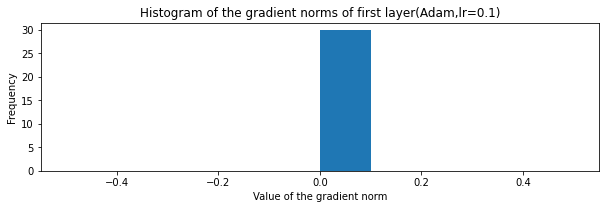

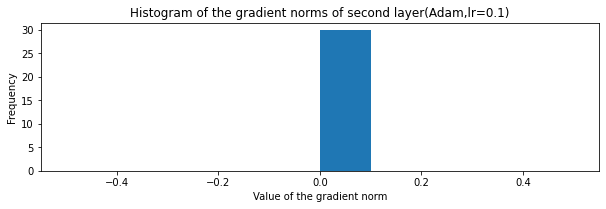

In [74]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer(Adam,lr=0.1)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(Adam,lr=0.1)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

#### **Training and Validation Loss Curves:**

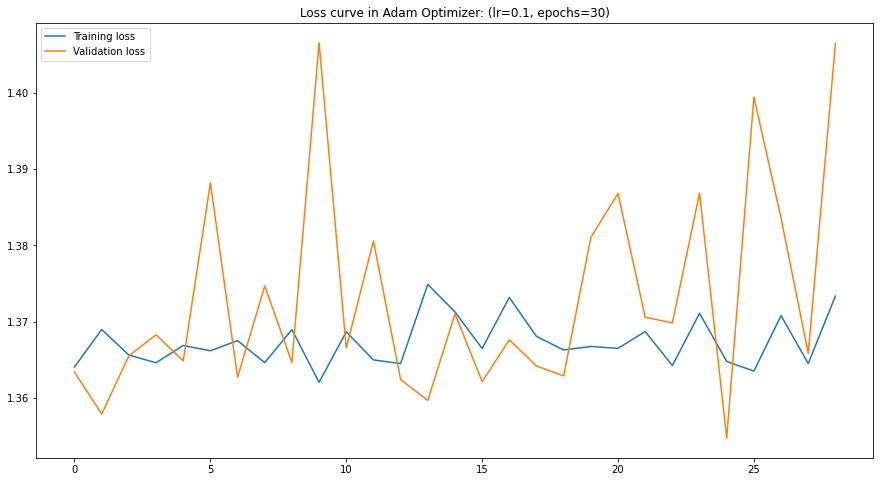

In [76]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_list_1[1:],label="Training loss")
plt.plot(valid_loss_list_1[1:],label="Validation loss")
plt.title("Loss curve in Adam Optimizer: (lr=0.1, epochs=30)")
plt.legend()
plt.show()




### **learning rate=0.01 ,epochs=30**

In [28]:
# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [29]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer

optimizer_adam2 = optim.Adam(model.parameters(), lr=0.01)

In [30]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

train_loss_list_2 = []
valid_loss_list_2 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_adam2.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_adam2.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
    train_loss_list_2.append(train_loss)
    valid_loss_list_2.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_weather.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.202337 	Validation Loss: 0.954036
conv1 grads tensor(0.8178, device='cuda:0')
conv2 grads tensor(0.3619, device='cuda:0')
Validation loss decreased (inf --> 0.954036).  Saving model ...
Epoch: 2 	Training Loss: 0.733601 	Validation Loss: 0.713184
conv1 grads tensor(9.5919, device='cuda:0')
conv2 grads tensor(2.5315, device='cuda:0')
Validation loss decreased (0.954036 --> 0.713184).  Saving model ...
Epoch: 3 	Training Loss: 0.608151 	Validation Loss: 0.902196
conv1 grads tensor(2.8658, device='cuda:0')
conv2 grads tensor(0.6806, device='cuda:0')
Epoch: 4 	Training Loss: 0.554379 	Validation Loss: 0.586793
conv1 grads tensor(1.0922, device='cuda:0')
conv2 grads tensor(0.6207, device='cuda:0')
Validation loss decreased (0.713184 --> 0.586793).  Saving model ...
Epoch: 5 	Training Loss: 0.513427 	Validation Loss: 0.555495
conv1 grads tensor(4.2078, device='cuda:0')
conv2 grads tensor(1.5725, device='cuda:0')
Validation loss decreased (0.586793 --> 0.555495).  S

#### **Distribution of the Gradient Norms:**

In [31]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())



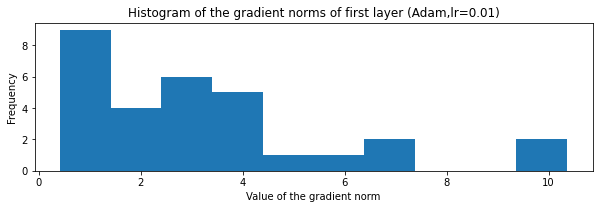

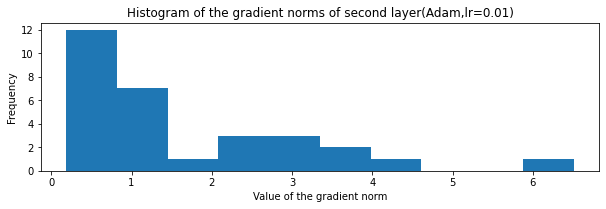

In [32]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (Adam,lr=0.01)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(Adam,lr=0.01)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

#### **Training and Validation Loss Curves:**

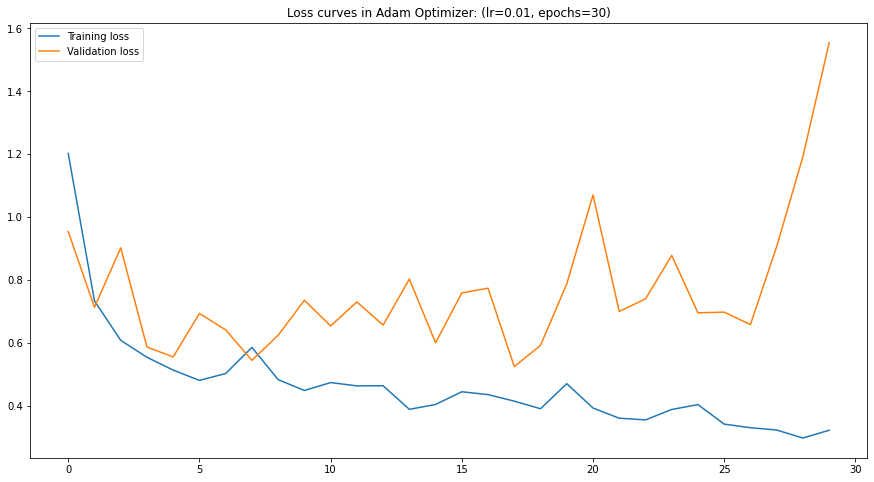

In [33]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_list_2,label="Training loss")
plt.plot(valid_loss_list_2,label="Validation loss")
plt.title("Loss curves in Adam Optimizer: (lr=0.01, epochs=30)")
plt.legend()
plt.show()


### **Adam Optimizer with lr=0.0001,100 epochs:**

In [88]:
# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [89]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer

optimizer_adam3 = optim.Adam(model.parameters(), lr=0.0001)

In [90]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss

train_loss_list_3 = []
valid_loss_list_3 = []

conv1_grad=[]
conv2_grad=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_adam3.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer_adam3.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    conv1_grad.append(torch.linalg.norm(model.conv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.conv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
    train_loss_list_3.append(train_loss)
    valid_loss_list_3.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_weather.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.358487 	Validation Loss: 1.325357
conv1 grads tensor(0.2001, device='cuda:0')
conv2 grads tensor(0.0664, device='cuda:0')
Validation loss decreased (inf --> 1.325357).  Saving model ...
Epoch: 2 	Training Loss: 1.206670 	Validation Loss: 1.064352
conv1 grads tensor(1.7896, device='cuda:0')
conv2 grads tensor(0.5739, device='cuda:0')
Validation loss decreased (1.325357 --> 1.064352).  Saving model ...
Epoch: 3 	Training Loss: 0.863639 	Validation Loss: 0.802058
conv1 grads tensor(2.1492, device='cuda:0')
conv2 grads tensor(1.0062, device='cuda:0')
Validation loss decreased (1.064352 --> 0.802058).  Saving model ...
Epoch: 4 	Training Loss: 0.672672 	Validation Loss: 0.695333
conv1 grads tensor(1.6270, device='cuda:0')
conv2 grads tensor(0.3838, device='cuda:0')
Validation loss decreased (0.802058 --> 0.695333).  Saving model ...
Epoch: 5 	Training Loss: 0.590587 	Validation Loss: 0.687712
conv1 grads tensor(0.8652, device='cuda:0')
conv2 grads tensor(0.1411, d

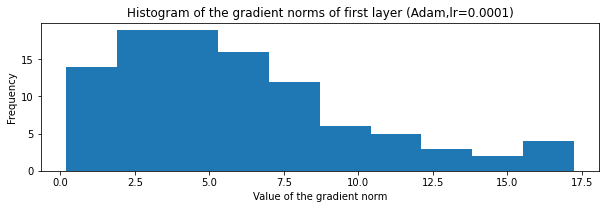

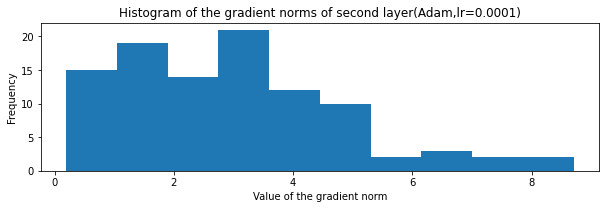

In [91]:
l1=[]
for i in conv1_grad:
    l1.append(i.item())

l2=[]
for i in conv2_grad:
    l2.append(i.item())


plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hist(l1)
plt.title("Histogram of the gradient norms of first layer (Adam,lr=0.0001)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.hist(l2)
plt.title("Histogram of the gradient norms of second layer(Adam,lr=0.0001)")
plt.xlabel("Value of the gradient norm")
plt.ylabel("Frequency")


plt.show()

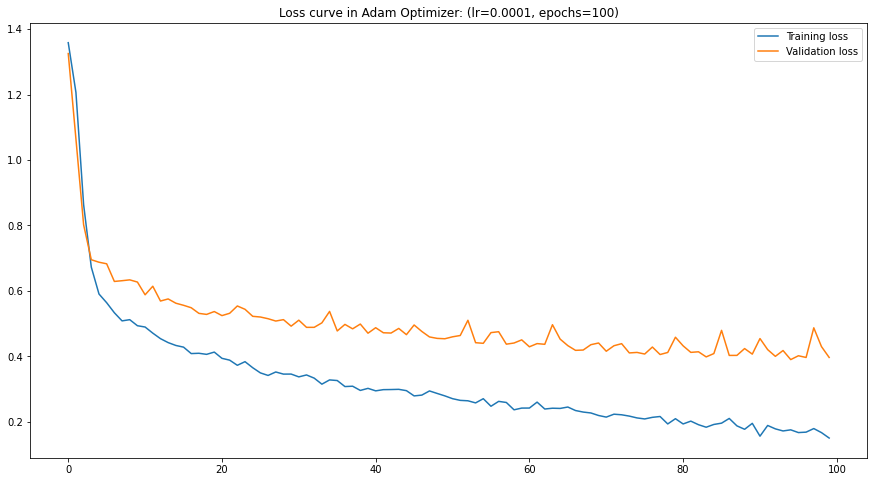

In [92]:
plt.figure(figsize=(15,8))
plt.plot(train_loss_list_3,label="Training loss")
plt.plot(valid_loss_list_3,label="Validation loss")
plt.title("Loss curve in Adam Optimizer: (lr=0.0001, epochs=100)")
plt.legend()
plt.show()

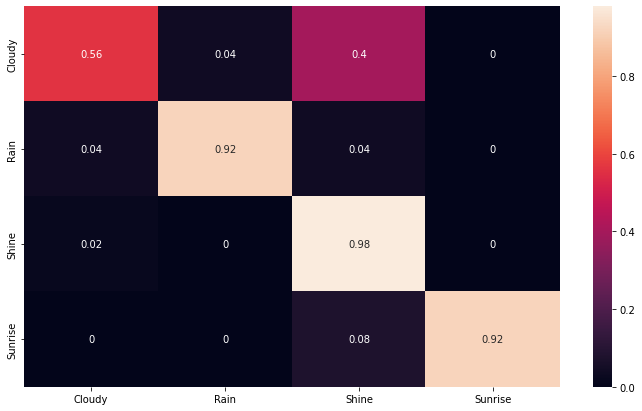

In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Cloudy', 'Rain', 'Shine', 'Sunrise')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *4, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)